# M6 - W9 - Assignment: Natural Language Processing with Disaster Tweets

# Project: Real or Fake - Disaster Tweets

Natural language processing (NLP) is an important and rapidly developing part of machine learning. New powerful  models (the so-called transformer type) appear regularly and each new one outperforms the previous one in a fundamental NLP task, such as question-answering, name-entity recognition, etc. However, often simple, classical methods tend to work quite well and are a good first approach to solve many NLP problems.

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src='tweet_screenshot.png' width="300" height="200">

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running. Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive. Acknowledgments: This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website.

In [1]:
# First things first, let's import the necessary packages:
import pandas as pd
import numpy as np
import re
from langdetect import detect
import eli5
from itertools import chain
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from collections import Counter
from collections import defaultdict


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, fbeta_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');
stop=set(stopwords.words('english'));




# Old Imports:
# import bz2
# from IPython.display import Image
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier # might not needed since we dont have categorical values

[nltk_data] Downloading package punkt to C:\Users\Moritz
[nltk_data]     Schreckenberg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Moritz
[nltk_data]     Schreckenberg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Moritz
[nltk_data]     Schreckenberg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


____
### Step 1: Download and import the training and testing data sets.

In [2]:
# Import the tweets
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


-

__Quick explanation to the columns:__
- id a unique identifier for each tweet
- text the text of the tweet
- location the location the tweet was sent from (may be blank)
- keyword a particular keyword from the tweet (may be blank)
- target in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
# Let's take a peak view into the df
# df = df.sample(200) # unhash to run code with little sample data only
df.iloc[1:8,3]

1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
Name: text, dtype: object

In [4]:
print('There are {} rows and {} columns in the train-data.'.format(df.shape[0],df.shape[1]))
print('There are {} rows and {} columns in the test-data.'.format(df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in the train-data.
There are 3263 rows and 4 columns in the test-data.


____
### Step 2: Preparation of the data and Explorative Data-Analysis

#### Step 2.1: Preprocessing the data (character handling, tokenizing, count etc.)
we will perform all kinds of pre-proccessing steps in order to transform the tweets into formats which are easily handled by a later model. Not only transforming the tweets, but also adding columns with additional information

In [5]:
# Pre-process: let's put all strings to miniscules:
df['text'] = df["text"].str.lower()

# Pre-process: Store the character-length of each tweet:
length_list = []
for k in df["text"]:
    length_list.append(len(k))
df["length"] = length_list


# Pre-process: Let's remove mentions "@xyz", typical for twitter tweets when you mention other users
pattern_ats = r"\@\w+"
text_wo_ats = []
for k in df["text"]:
    wo_ats = re.sub(pattern_ats, " ", k) # Let's replace all mentions and symbols with white spaces 
    text_wo_ats.append(wo_ats)

df["text"] = text_wo_ats


# Pre-process: Let's remove web-page links
pattern_webpage = r"http\S+"
text_wo_webpage = []
for k in df["text"]:
    wo_webpage = re.sub(pattern_webpage, " ", k) # Let's replace all webpages and symbols with white spaces 
    text_wo_webpage.append(wo_webpage)

df["text"] = text_wo_webpage

# Pre-process: Let's remove symbols
pattern_sym = r"[^\w]"
text_wo_symbols = []
for k in df["text"]:
    wo_symbol = re.sub(pattern_sym, " ", k) # Let's replace all special characters and symbols with white spaces 
    text_wo_symbols.append(wo_symbol)

df["text"] = text_wo_symbols

# We could remove digits, but I guess it's better to keep digits
# # Pre-process: Let's remove digits
# pattern_dig = r"(\d+)"
# text_wo_digits = []
# for k in df["text"]:
#     wo_digits = re.sub(pattern_dig, " ", k) 
#     text_wo_digits.append(wo_digits)
# df["text"] = text_wo_digits


# Let's create a pattern (regular expression) to seperate the words
pattern =  r"\s+"

tokens_per_tweet = []
tokens_count = []
j_counter = 0

for k in df["text"]:
#     print(k)
    tokens_per_tweet.append(re.split(pattern,k))
    tokens_count.append(len(tokens_per_tweet[j_counter]))
    j_counter += 1
#     print(" - - -",len(tokens_per_tweet[j_counter-1]),"\n")

# Now that we split and counted the tokens let's add this information to the df
df["count"] = tokens_count

In [6]:
# During scanning the tweets, we found other characters, that still remain
# Let's remove these characters as well
list_of_additional_special_characters = ["û_","ûªs","ûªt","ûò"]

char_to_replace = {'û_': '',
                   'ûªs': '',
                   'ûªt': '',
                   'ûò': ''}

# Replace all multiple characters in a string
# based on translation table created by dictionary
tanslated_strings = []
for row in df["text"]:
    for char in list_of_additional_special_characters:
        tanslated_strings.append(row.replace(char," "))

df["text"]

0       our deeds are the reason of this  earthquake m...
1                  forest fire near la ronge sask  canada
2       all residents asked to  shelter in place  are ...
3       13 000 people receive  wildfires evacuation or...
4       just got sent this photo from ruby  alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609        the out of control wild fires in californi...
7610         m1 94  01 04 utc  5km s of volcano hawaii   
7611    police investigating after an e bike collided ...
7612    the latest  more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [7]:
# Let's quickly validate if we read through all lines of the df
if len(tokens_per_tweet) == len(df["text"]):
    print("All words in each review-line have been read.")

All words in each review-line have been read.


In [8]:
print("In total the reivews have ca.",round((df["count"].sum())/1000,0),"thousand words/tokens.")

In total the reivews have ca. 116.0 thousand words/tokens.


In [9]:
# Let's take a peak view into the df
df["text"].sample(20)

4104    hi res doppler showing storm just ne of edmond...
4009    etp bengal floods  cm mamata banerjee blames d...
414           alleged east bay serial arsonist arrested  
5319     breaking 10th death confirmed in legionnaires...
3546    top 3    turn on the darkness   king redeem   ...
1858                  que crush  mtvhottest justin bieber
3863    maryland mansion fire that killed 6 caused by ...
6126    i just made a weird high pitched noise and the...
5629    short of throwing them overboard himself i don...
5848    like why on earth would you want anybody to be...
7452    if time heals all wounds how come the belly bu...
3008                            dust storm in riyadh     
114     320  ir  icemoon  aftershock             dubst...
733                     yes i m a bleeding heart liberal 
6198                               smoke whatever you got
6669    meek mill responds to drake ûªs ovo fest set w...
951           glononium 6c also helps with being blown...
2707    detona

In [10]:
# let's do this with the packages word_tokenize and Counter

# Now let's devide into tokens
tokens = []
for k in df["text"]:
    tokens.append(word_tokenize(k))

# Pre-process: Let's stemm/lemmitize each token
lemmatizer = WordNetLemmatizer()
lemmed_tokens = []

for unlemms in tokens:
    k = unlemms
    lems = []
    for j in k:
        lem = lemmatizer.lemmatize(j)
        lems.append(j)
    lemmed_tokens.append(lems)

df["text_tokens"] = lemmed_tokens

# Create a second token_count column to double-check:
count = []
total_count = []

for j in df["text"]:
    count.append(Counter(j))
    total_count.append(len(Counter(j)))

df["count_excl._duplicates"] = total_count


df.sample(20)

,id,keyword,location,text,target,length,count,text_tokens,count_excl._duplicates
825,1201,blizzard,Ontario Canada,my mic and controllers aren t working one second,0,48,9,"[my, mic, and, controllers, aren, t, working, ...",17
2023,2905,danger,NaN,dad i won t chase you constantly amp al...,0,146,24,"[dad, i, won, t, chase, you, constantly, amp, ...",23
6159,8785,siren,NaN,outdoor siren test 2pm the fgcu siren will ...,0,126,24,"[outdoor, siren, test, 2pm, the, fgcu, siren, ...",22
5166,7367,obliterate,NaN,time to obliterate this sin,0,28,6,"[time, to, obliterate, this, sin]",13
3305,4736,evacuate,Sevier County.,so all the store s fire alarms went off today ...,1,123,28,"[so, all, the, store, s, fire, alarms, went, o...",22
1031,1497,body%20bags,NaN,attention all rchs football players there will...,0,132,23,"[attention, all, rchs, football, players, ther...",22
2364,3401,demolition,NaN,canberra s first mr fluffy homes demolition sc...,0,85,10,"[canberra, s, first, mr, fluffy, homes, demoli...",18
1328,1919,burning,New York,2 burning man tickets vehicle pass full re...,0,102,11,"[2, burning, man, tickets, vehicle, pass, full...",22
3498,4998,explosion,"Long Island, NY",we found a sunflower explosion on our walk,1,89,9,"[we, found, a, sunflower, explosion, on, our, ...",16
1725,2488,collided,"Peterborough, Ont.",newswatch 2 vehicles collided at lock and la...,1,92,17,"[newswatch, 2, vehicles, collided, at, lock, a...",22


In [11]:
# Not needed for these cleaned tweets but can be helpful in reallife tweet-scraping:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

#### Step 2.2: EDA

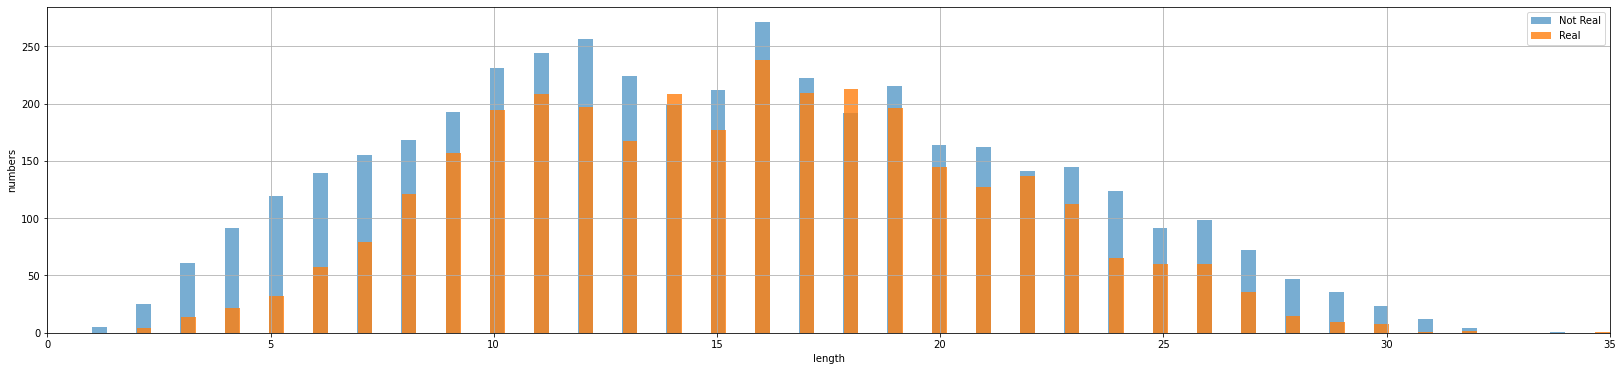

In [12]:
plt.rcParams['figure.figsize'] = (28, 6)
bins = 100
plt.hist(df[df['target'] == 0]['count'], alpha = 0.6, bins=bins, label='Not Real')
plt.hist(df[df['target'] == 1]['count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,35)
plt.grid()
plt.show()

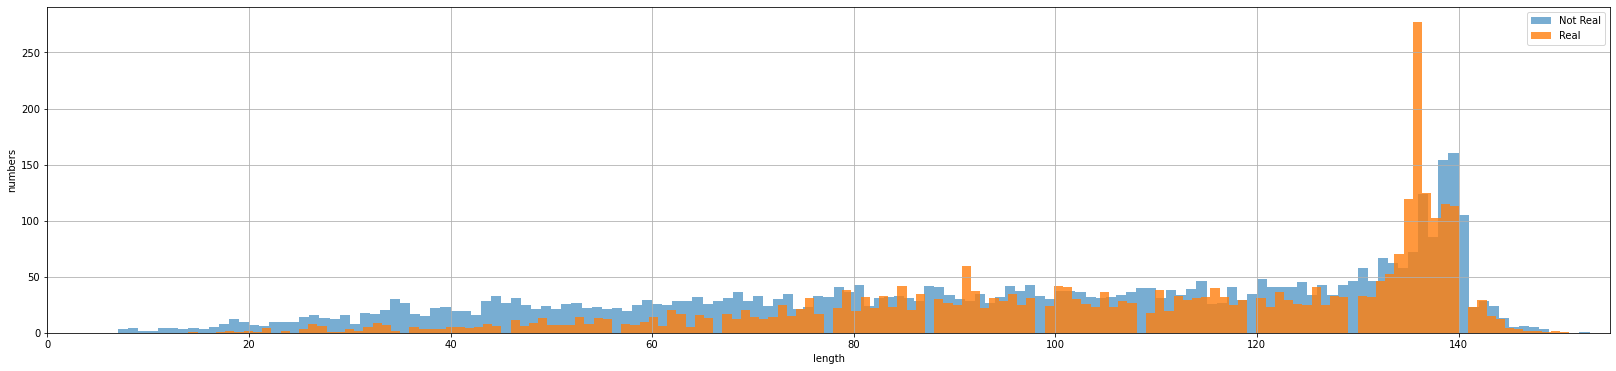

In [13]:
plt.rcParams['figure.figsize'] = (28, 6)
bins = 150
plt.hist(df[df['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not Real')
plt.hist(df[df['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,155)
plt.grid()
plt.show()

In [14]:
# Let's create a function to list all tokens within a single list
def longlist_tokens(target):
    longlist_of_tokens = []
    
    for x in df[df['target'] == target]['text'].str.split():
        for i in x:
            longlist_of_tokens.append(i)
    return longlist_of_tokens 

In [15]:
# Lets look at tweets that are not real:
corpus = []
corpus = longlist_tokens(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

# displaying the stopwords
np.array(stop)

array({'doing', 'ours', 'only', 'd', 'being', 'mightn', 'not', 'did', 'was', "shan't", 'hasn', 'off', 'itself', "she's", 'this', 'y', 'ourselves', 'wouldn', 'were', 'ain', 'have', "it's", "weren't", "you'll", 'should', 'whom', 'she', 'you', 'he', 'some', 'down', 'about', "haven't", 'now', 'a', 'i', 'few', 'm', "wasn't", 'can', 'my', 'in', 'shan', 'shouldn', "you're", 'him', "needn't", 're', 'each', 'o', "shouldn't", 'nor', "should've", 'after', 'having', "aren't", 'again', 'own', 'an', 'before', 'most', 'from', "didn't", 'against', "hadn't", 'themselves', 'haven', 'but', "you'd", 'those', 'below', 'their', 'here', 'with', 'doesn', "won't", "don't", 'over', 'wasn', "mightn't", 'does', 'as', 'while', 'than', 'been', 'do', 'same', 'needn', 'myself', 'which', 'her', 'between', 'mustn', 'hers', 'during', 'himself', 'just', 'then', 'isn', 'who', "mustn't", 'the', 'up', 'until', "wouldn't", 'these', 'couldn', "doesn't", 'them', 'didn', 'so', 'are', 'by', 'me', 'your', 'be', 'of', 'how', 'thro

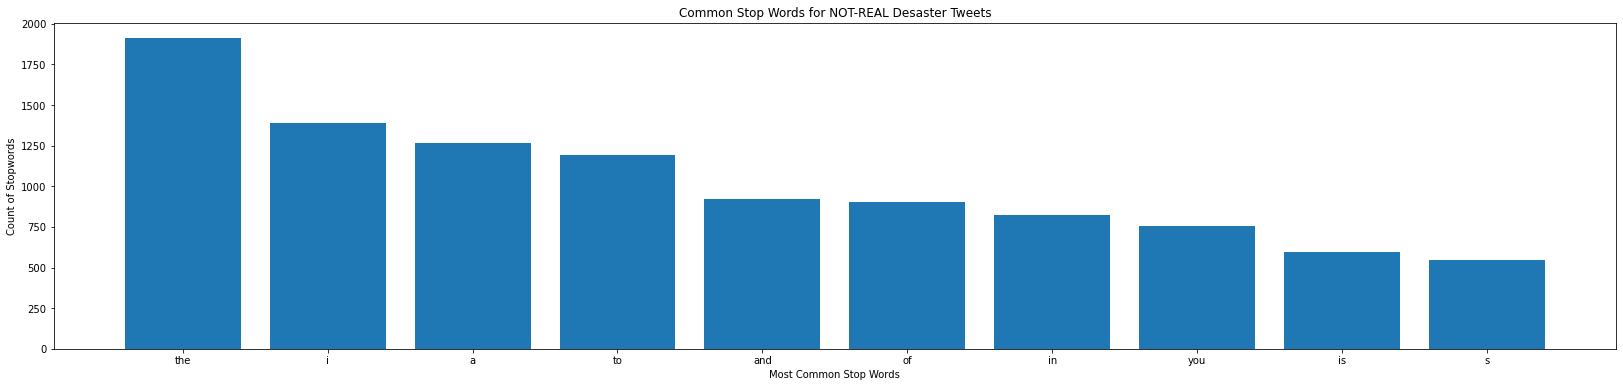

In [16]:
plt.rcParams['figure.figsize'] = (28, 6)
x,y=zip(*top)
plt.title("Common Stop Words for NOT-REAL Desaster Tweets")
plt.xlabel("Most Common Stop Words")
plt.ylabel("Count of Stopwords")
plt.bar(x,y)
plt.show()

In [17]:
# Lets look at tweets that are real:
corpus = []
corpus=longlist_tokens(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

# displaying the stopwords
np.array(stop)

array({'doing', 'ours', 'only', 'd', 'being', 'mightn', 'not', 'did', 'was', "shan't", 'hasn', 'off', 'itself', "she's", 'this', 'y', 'ourselves', 'wouldn', 'were', 'ain', 'have', "it's", "weren't", "you'll", 'should', 'whom', 'she', 'you', 'he', 'some', 'down', 'about', "haven't", 'now', 'a', 'i', 'few', 'm', "wasn't", 'can', 'my', 'in', 'shan', 'shouldn', "you're", 'him', "needn't", 're', 'each', 'o', "shouldn't", 'nor', "should've", 'after', 'having', "aren't", 'again', 'own', 'an', 'before', 'most', 'from', "didn't", 'against', "hadn't", 'themselves', 'haven', 'but', "you'd", 'those', 'below', 'their', 'here', 'with', 'doesn', "won't", "don't", 'over', 'wasn', "mightn't", 'does', 'as', 'while', 'than', 'been', 'do', 'same', 'needn', 'myself', 'which', 'her', 'between', 'mustn', 'hers', 'during', 'himself', 'just', 'then', 'isn', 'who', "mustn't", 'the', 'up', 'until', "wouldn't", 'these', 'couldn', "doesn't", 'them', 'didn', 'so', 'are', 'by', 'me', 'your', 'be', 'of', 'how', 'thro

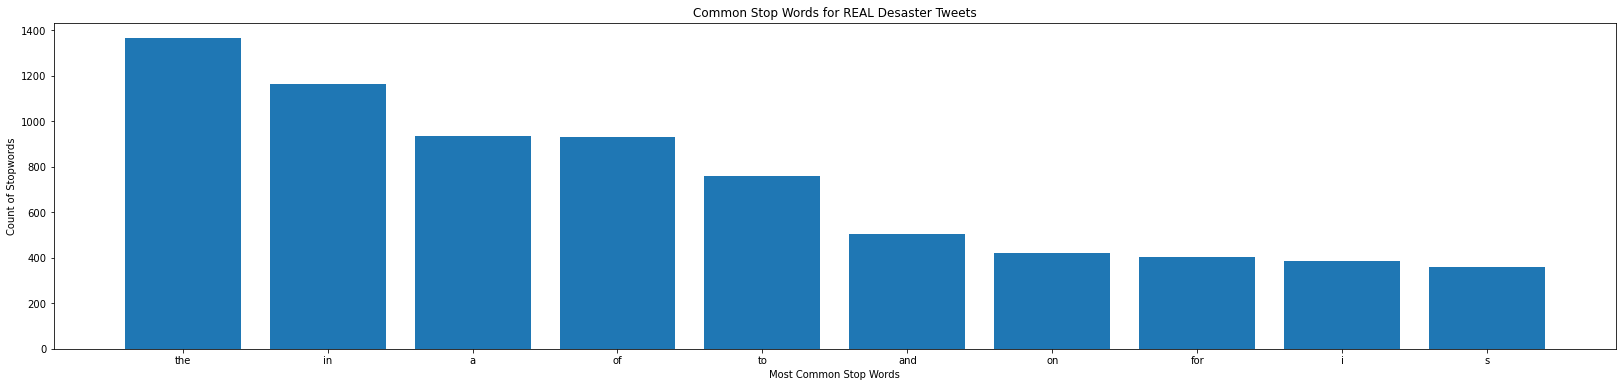

In [18]:
plt.rcParams['figure.figsize'] = (28, 6)
x,y=zip(*top)
plt.title("Common Stop Words for REAL Desaster Tweets")
plt.xlabel("Most Common Stop Words")
plt.ylabel("Count of Stopwords")
plt.bar(x,y)
plt.show()

____
### Step 3: Build prediction model 


In [19]:
# Let's now detect the language of each review and add this information to the df (Note: This takes a while, ~6min with 50k reviews)
language_list = []

for k in df["text"]:
    language_of_review = detect(k)
    language_list.append(language_of_review)

In [20]:
df["language"] = language_list
df

,id,keyword,location,text,target,length,count,text_tokens,count_excl._duplicates,language
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,69,13,"[our, deeds, are, the, reason, of, this, earth...",20,en
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38,7,"[forest, fire, near, la, ronge, sask, canada]",15,no
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,133,22,"[all, residents, asked, to, shelter, in, place...",22,en
3,6,NaN,NaN,13 000 people receive wildfires evacuation or...,1,65,10,"[13, 000, people, receive, wildfires, evacuati...",20,en
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,88,17,"[just, got, sent, this, photo, from, ruby, ala...",23,en
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,83,11,"[two, giant, cranes, holding, a, bridge, colla...",19,en
7609,10870,NaN,NaN,the out of control wild fires in californi...,1,125,20,"[the, out, of, control, wild, fires, in, calif...",21,en
7610,10871,NaN,NaN,m1 94 01 04 utc 5km s of volcano hawaii,1,65,11,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw...",21,en
7611,10872,NaN,NaN,police investigating after an e bike collided ...,1,137,23,"[police, investigating, after, an, e, bike, co...",22,en


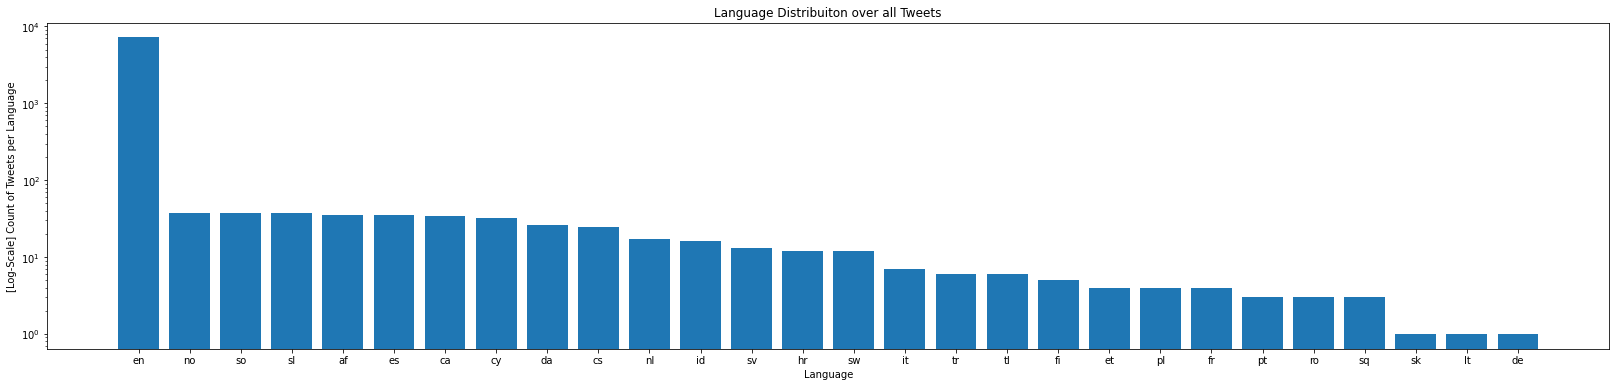

In [21]:
# Let's see what languages we detected in the reviews (out of curiosity):
df["language"].value_counts()

plt.rcParams['figure.figsize'] = (28, 6)
x,y = (df["language"].unique(),df["language"].value_counts())
plt.title("Language Distribuiton over all Tweets")
plt.xlabel("Language")
plt.ylabel("[Log-Scale] Count of Tweets per Language")
plt.bar(x,y)
plt.yscale('log')
plt.show()

In [22]:
df_nen = df[df["language"] != "en"]
df_nen

,id,keyword,location,text,target,length,count,text_tokens,count_excl._duplicates,language
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38,7,"[forest, fire, near, la, ronge, sask, canada]",15,no
16,24,NaN,NaN,i love fruits,0,13,3,"[i, love, fruits]",11,no
19,28,NaN,NaN,what a goooooooaaaaaal,0,28,4,"[what, a, goooooooaaaaaal]",8,so
22,33,NaN,NaN,love skiing,0,11,2,"[love, skiing]",10,sl
24,36,NaN,NaN,looooool,0,8,1,[looooool],2,so
...,...,...,...,...,...,...,...,...,...,...
7495,10722,wreck,"Greenville, S.C.",greer man dies in wreck,1,46,6,"[greer, man, dies, in, wreck]",13,af
7530,10768,wreckage,NaN,wreckage is mh370 najib mh370 najibrazak ...,1,84,7,"[wreckage, is, mh370, najib, mh370, najibrazak...",21,sw
7561,10810,wrecked,6,lol u got wrecked,0,29,5,"[lol, u, got, wrecked]",12,cy
7572,10823,wrecked,"Manhattan, NY",did you get wrecked again,1,49,7,"[did, you, get, wrecked, again]",15,cy


- Tweets detect as non-english apear to be english. So we keep all tweets and disregard the language-detect function
- For future use, we know that the function is not a 100%-reliable

In [23]:
# Let's quickly transform the NaNs in the column "keyword"
df["keyword"].fillna("None", inplace=True)


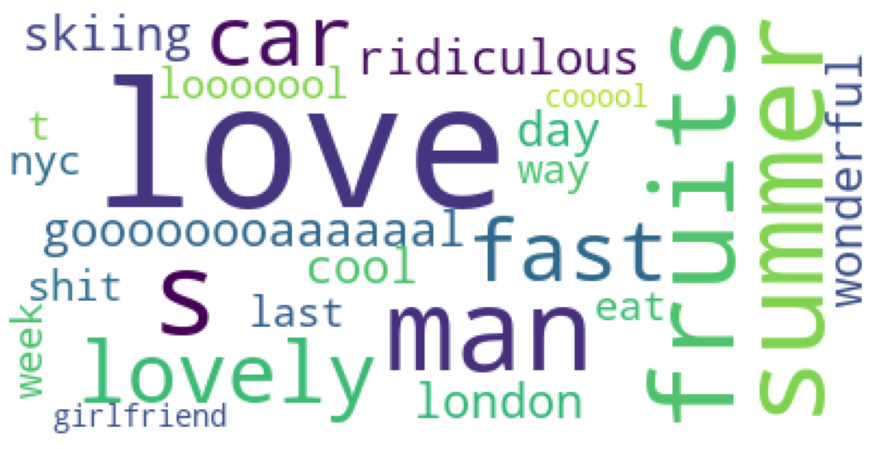

In [24]:
# Let's check the differences in the top used tokens for fake and real desaster tweets

corpus = longlist_tokens(0)

# Generating a Wordcloud with Fake-Desaster-Tweets
plt.figure(figsize=(28,8))
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(corpus[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

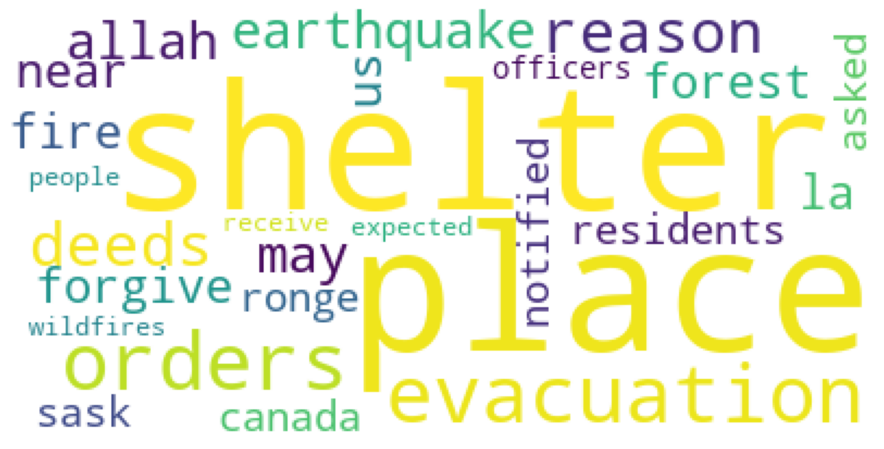

In [25]:
corpus = longlist_tokens(1)

# Generating a Wordcloud with Fake-Desaster-Tweets
plt.figure(figsize=(28,8))
word_cloud = WordCloud(background_color='white',max_font_size = 80).generate(" ".join(corpus[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

____
### Step 4: Testing and Submission
You can use the CountVectorizer module from sklearn but limit the maximum number of features to be 500 to avoid memory issues and you can even decrease it further if you still have memory issues. Explore the other parameters of the function as well.<br>

In [26]:
# Typically BoW is a helpful method to vectorize text
# we have imported the CountVectorizer from sklearn (see above)

# We still have many common tokens in the list, which are not really giving any meaning or hints for sentiments
# Let's try to filter for "insignificant" tokens (also called "stop words")
stop_words = set(stopwords.words('english'))
# print(stop_words)

# Let's define the function
vectorizer = CountVectorizer(max_features=500, stop_words = stop_words)
vectorizer_keywords = CountVectorizer(max_features=100, stop_words = stop_words)
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1, max_features=500)

# Let's vectorize the reviews
X = vectorizer.fit_transform(df["text"]).toarray()
X_key = vectorizer_keywords.fit_transform(df["keyword"]).toarray()
X2 = bigram_vectorizer.fit_transform(df["text"]).toarray()
print("The shape of our first vector:",X.shape,"\nThe shape of our second bigram vector:",X2.shape)

The shape of our first vector: (7613, 500) 
The shape of our second bigram vector: (7613, 500)


In [27]:
# ---- Second option for transforming into a df ----
# Let's transform the array of tweets to a list to add to the df
df_tweets_bow_vector = pd.DataFrame(X, columns= vectorizer.fit(df["text"]).get_feature_names())
df_tweets_bow_vector.head()

,00,05,08,10,11,15,2015,30,40,50,...,wreckage,wrecked,year,years,yet,zone,û_,ûª,ûªs,ûò
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Let's transform the array of tweets to a list to add to the df
df["keyword"].fillna("NaN",inplace=True)
df_keywords_bow_vector = pd.DataFrame(X_key, columns= vectorizer_keywords.fit(df["keyword"]).get_feature_names())
df_keywords_bow_vector.head()

,20bags,20buildings,20disaster,20emergency,20fall,20fire,20fires,20reactor,20spill,20storm,...,typhoon,upheaval,weapon,weapons,whirlwind,windstorm,wounded,wreck,wreckage,wrecked
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Let's take apart the steps, and redo them manually to better understand:

# Let's use a simple list comprehension to transform the list of arrays to one joint list
list_of_tokens = [list(x) for x in tokens_per_tweet] # from Top Question 2
list_of_all_tokens = list(chain(*list_of_tokens))

print("We now have",len(list_of_all_tokens),"tokens in a single list.")

We now have 115861 tokens in a single list.


In [30]:
# Let's vectorize this list for the most common 1000 tokens:
counted_common_tokens = Counter(list_of_all_tokens).most_common(1000)

# Let#s manually filter:
filtered_tokens = []
for w in list_of_all_tokens:
    if w not in stop_words:
        filtered_tokens.append(w)

# Let's check the filtered tokens        
# print(filtered_tokens)

# Let's vectorize this list for the most common 1000 tokens:
counted_common_tokens = Counter(list_of_all_tokens).most_common(100)
counted_common_filtered_tokens = Counter(filtered_tokens).most_common(100)
print(counted_common_filtered_tokens)

[('', 7408), ('like', 348), ('amp', 344), ('û_', 343), ('fire', 254), ('get', 229), ('new', 226), ('via', 220), ('2', 214), ('people', 199), ('news', 196), ('one', 196), ('video', 165), ('disaster', 158), ('emergency', 158), ('police', 143), ('would', 137), ('u', 135), ('3', 133), ('body', 131), ('still', 129), ('us', 124), ('california', 121), ('storm', 121), ('burning', 121), ('back', 120), ('crash', 119), ('suicide', 119), ('day', 118), ('man', 116), ('time', 116), ('got', 113), ('know', 113), ('1', 113), ('buildings', 111), ('first', 109), ('rt', 108), ('world', 106), ('see', 105), ('bomb', 105), ('going', 104), ('nuclear', 104), ('two', 103), ('fires', 102), ('love', 101), ('attack', 101), ('today', 100), ('killed', 99), ('dead', 98), ('year', 98), ('go', 97), ('5', 96), ('car', 94), ('gt', 94), ('4', 94), ('full', 94), ('û', 94), ('train', 93), ('hiroshima', 93), ('life', 92), ('war', 92), ('old', 92), ('let', 90), ('accident', 89), ('good', 89), ('may', 88), ('families', 88), ('

A few observations:
- It looks like we still count "" as a token
- The token ''û_' shows, that we have not yet successfully handled all special characters, for now thoug, we keep it
- All the above is easily handled with the CountVectorizer-function

____
### Step 5: Build and train a model to predict sentiments of a review
Use the fitted and transformed vector and the above created features. Note that this will be a classification problem. Evaluate your model and motivate your choice of a performance metric. (Hint: the feature for language is of type ‘object’, you may want to transform it to binary, such that it is 1 if the language is in English, 0 otherwise).

In [31]:
# Before we start modeling let's reduce the dataframe to what we actually need for the model (no tokens, no other languages than english)
df_reduced = df.copy()
df_reduced.drop(["id","keyword","location","text","text_tokens","count_excl._duplicates","language"], axis = 1, inplace= True)
df_reduced

,target,length,count
0,1,69,13
1,1,38,7
2,1,133,22
3,1,65,10
4,1,88,17
...,...,...,...
7608,1,83,11
7609,1,125,20
7610,1,65,11
7611,1,137,23


In [32]:
# Let's concat the reduced df and the bow-vector of the tweets
df_reduced.reset_index(drop=True, inplace=True)
df_tweets_bow_vector.reset_index(drop=True, inplace=True)

df_joined = pd.concat([df_reduced, df_tweets_bow_vector], axis=1)


# Let's merge the upper joined df with the bow-vector of the kexwords
df_keywords_bow_vector.reset_index(drop=True, inplace=True)
df_joined.reset_index(drop=True, inplace=True)

df_joined = pd.concat([df_joined, df_keywords_bow_vector], axis=1)

df_joined.sample(10)

,target,length,count,00,05,08,10,11,15,2015,...,typhoon,upheaval,weapon,weapons,whirlwind,windstorm,wounded,wreck,wreckage,wrecked
0,1,69,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,38,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,133,22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,65,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,88,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,1,83,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,1,125,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,1,65,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,1,137,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Lets define X, y for our model
X = df_joined.drop("target", axis=1)
y = df_joined["target"]

In [34]:
# Let's now split the data into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Split of train and test should have been done earlier, we consider that when discussing the results

# Let's build and fit the model
normalizer = StandardScaler()
model = LogisticRegression(C=1, random_state=42, n_jobs=-1)
pipeline = make_pipeline(normalizer, model)
model.fit(X, y)
pred = model.predict(X_test)

In [35]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[1161  142]
 [ 269  712]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1303
           1       0.83      0.73      0.78       981

    accuracy                           0.82      2284
   macro avg       0.82      0.81      0.81      2284
weighted avg       0.82      0.82      0.82      2284



Let's discuss these metrics:
- In our case it seems most relevant to have a high percentage of correct guesses
- It is not crucial to avoid false positives
- Therefore we primarily focus on precision. It is currently at ~82%, which is quite high already (from my experience and compared to the RandomForestClassifier below)
- Hence we do not need to improve further on that end and keep the LogisticRegressor Model

In [36]:
# RandomForestClassifier: Let's build and fit the model
modelRFC = RandomForestClassifier(max_depth=45, random_state=0)
modelRFC.fit(X, y)
pred = modelRFC.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1303
           1       0.99      0.65      0.78       981

    accuracy                           0.84      2284
   macro avg       0.89      0.82      0.83      2284
weighted avg       0.87      0.84      0.84      2284



In comparison to the Logistic Regression Model the RFC lacks behind
- Recall value for real desater tweets is pretty low in RFC-Model with ~67%

--- __Further possible improvements__ ---
-  <span style="color:green">Improve preprocess by taking out some additional special characters, that I found in very specific tweets </span>.
- Improve code when building, fitting and running the model with pipelines
- Run the test/train/split before performing all pre-processes on the data
- Build a DeepLearning model (see last two blocks of code from the BACKUP)
- Check out the confusion matrix to help compare different models against one another
- Build a BERT model, since it has been proven to work quite well with texts


_____________
_____________
### BACKUP

In [37]:
# Let's look at the most impacting tokens
# eli5.show_weights(estimator=model, feature_names= list(df_joined.iloc[:,1:].columns), top=(25,25)) #feature_names= list(df_joined.columns.drop("score"))

In [38]:
# # Alternative way of reading the file - since the provided code does not work properly:

# # Open the data file
# file = open("train.ft.txt", encoding='utf-8')
# # read the file as a list
# data = file.readlines(200000000)
# # close the file
# file.close()

In [39]:
# # Let's vectorize the reviews
# bow_vector_X = []
# bow_vector_X2 = []
# for k in tokens_per_review:
#     X = vectorizer.fit_transform(k).toarray()
#     X2 = bigram_vectorizer.fit_transform(tokens_per_review[1]).toarray()
#     bow_vector_X.append(X)
#     bow_vector_X2.append(X2)

In [40]:
# # Let's unfold the bow_vector_X to single columns
# vector_columns = pd.DataFrame(df_reduced["bow_vector_X"].tolist())

# # To correctly concat the df, let's reset the indexes
# vector_columns.reset_index(drop=True, inplace=True) # Old vector without correct naming of the columns
# df_reduced.reset_index(drop=True, inplace=True)
# df_bow_vector.reset_index(drop=True, inplace=True)


# print(len(df_bow_vector),len(vector_columns),len(df_reduced))

In [42]:
# ---- First option for transforming into a df ----
# Let's transform the array to a list to add to the df
# list_X = []
# for k in X:
#     list_X.append(k)

# list_X2 = []
# for j in X2:
#     list_X2.append(j)
    
# df["bow_vector_X"] = list_X
# df["bow_vector_X2"] = list_X2

In [43]:
# Import of DeepLearning packages
import keras
import tensorflow as tf

# import of DL-layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
from keras.models import Sequential, load_model


In [ ]:
# For a binary classification problem
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

In [ ]:
# Let's fit the model, and count the time taken
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutes: {final_time}')